![title](https://image.ibb.co/erDntK/logo2018.png)

---



# Task 14 - Variational  AutoEncoder


An **Autoencoder** is a neural network which is an unsupervised learning algorithm which uses back propagation to generate output value which is almost close to the input value. It takes input such as image or vector anything with a very high dimensionality and run through the neural network and tries to compress the data into a smaller representation.

<p align='center'>
<img src='https://www.researchgate.net/profile/Xifeng_Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png' width=80% />


While the basic idea behind a **Variational Autoencoder** is that instead of mapping an input to fixed vector, input is mapped to a distribution. The only difference between the autoencoder and variational autoencoder is that bottleneck vector is replaced with two different vectors one representing the mean of the distribution and the other representing the standard deviation of the distribution.

<p align='center'>
<img src="https://i.ibb.co/tHyP83k/vae.png" width=80% />

In this notebook we will examine the difference between Vanilla (Convolutional) AutoEncoder and Variational AutoEncoder in generating MNIST images

Write down your Name and Student ID

In [0]:
## --- start your code here ----

NIM = 1301160098
Nama = "Panji Bagaskara"

## --- end your code here ----

---
---
#[Part 0] Import Libraries and Load Data

---
## 1 - Install TensorFlow 2

If Tensorflow 2 is not already installed, install it first

In [0]:
!pip install tensorflow-gpu -q

In [52]:
import tensorflow as tf
tf.__version__

'2.0.0'

**EXPECTED OUTPUT**:
<pre>
 '2.0.0'

---
## 2 - Import Modul

In [0]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose

from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import imageio
import glob

np.set_printoptions(precision=4)

---
## 3 - Load MNIST Dataset

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test  = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

---
## 4 - Helper Functions

Below are several helper functions to visualize the generated image

---
### a. Plot Latent Space

This function visualize the latent space distribution extracted from `encoder` model

In [0]:
def plot_latent_space(encoder_model, data, batch_size=128, vae=False):

    x, y = data
    if vae:
        z, _, _ = encoder_model.predict(x, batch_size=batch_size)
    else:
        z       = encoder_model.predict(x, batch_size=batch_size)

    print('z range: ('+str(np.min(z))+','+str(np.max(z))+')')
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


---
### b. Generate Image

This function generate &nbsp;$ n $ &nbsp;images from random latent space &nbsp;$ z $  &nbsp;. 

The default range of &nbsp;$ z $  &nbsp; is $(-1..1)$

In [0]:
def generate_image(decoder_model, z_range=(-1,1), n=5):
    a,b = z_range
    z_sample = np.random.uniform(a, b, (n, 2))
    x_decoded = decoder_model.predict(z_sample)

    fig, ax = plt.subplots(1,n,figsize=(15,4.5))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(n):
        digit = x_decoded[i].reshape(28, 28)
        ax[i].imshow(digit, cmap='gray')
        ax[i].set_title(str(z_sample[i]))
        ax[i].axis('off')
    plt.show()

---
### c. Plot Interpolating Images
This function generate &nbsp;$n\times n$&nbsp; interpolating images generated from latent space &nbsp;$z$&nbsp;

The default range of &nbsp;$ z $  &nbsp; is $(-1..1)$

In [0]:
def plot_interpolating(decoder_model, z_range=(-1,1), n=20, 
                       save=False, filename='img.png', 
                       figsize=(10, 10)):

    # display a 30x30 2D manifold of digits
    a,b = z_range
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(a, b, n)
    grid_y = np.linspace(a, b, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_model.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    start_range    = digit_size // 2
    end_range      = n * digit_size + start_range + 1
    pixel_range    = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    fig = plt.figure(figsize=figsize)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')

    if save:
        plt.savefig(filename)
        plt.close(fig)
    else:
        print('range:(',a,':',b,')')
        plt.show()

---
### d. Save Image Callback

This class defines a Keras callback to save interpolating image generated each training epoch

In [0]:
class SaveImage(tf.keras.callbacks.Callback):
    def __init__(self, decoder=None, base_dir=None):
        super(SaveImage, self).__init__()
        self.decoder = decoder
        self.base_dir = base_dir

    def on_epoch_end(self, epoch, logs={}):
        filename = self.base_dir+'/image'+str(epoch)+'.png'
        plot_interpolating(self.decoder, z_range=(-1,1), n=5,
                           save=True, filename=filename, 
                           figsize=(5,5))
        

---
### e. Generate GIF

This function generate a GIF animation formt the saved images

In [0]:
def show_gif(base_dir, anim_file):    
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = (i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    print('GIF saved as', anim_file)

---
---
# [Part 1] Convolutional AutoEncoder

Now let's build our Convolutional AutoEncoder

<center>
<img src='https://miro.medium.com/max/1578/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png' width=60%>

---
## 1 - Conv-AE Encoder

First, define the Encoder model

The architechture is as follow:
<pre>
    * the input shape is 3-dimensional <font color='blue'><b>(28,28,1)</b></font>  
    * <b>conv</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * <b>conv</b> layer with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * flatten layer
    * <b>dense</b> layer with <font color='blue'><b>16</b></font> neurons using relu activation
    * output <b>dense</b> layer with <font color='blue'><b>2</b></font> neuron without activation
</pre>

---
#### <font color='red'>**EXERCISE:** </font>

*  build encoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED

In [0]:
input_shape = (image_size, image_size, 1)
latent_dim  = 2

# create Input() with shape of input_shape
# set the name as 'encoder_input'
encoder_input = Input(shape=input_shape, name='encoder_input')

# add conv2d layer to encoder_input with 32 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='SAME') (encoder_input)

# add conv2d layer to x with 64 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)

# add flatten layer to x 
x = Flatten() (x)

# add dense layer to x with 16 neurons and relu activation
x = Dense(16, activation='relu') (x)

# add output layer to x using dense layer with latent_dim neurons, without activation
# set the name as 'encoder_output'
encoder_output = Dense(latent_dim, name='encoder_output') (x)


---
#### <font color='red'>**EXERCISE:** </font>
* instantiate encoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [61]:
# call Model() function with input encoder_input and encoder_output
# set the model name as 'ae_encoder'
ae_encoder = Model(encoder_input, encoder_output, name='ae_encoder')

ae_encoder.summary()

Model: "ae_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                50192     
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 34        
Total params: 69,042
Trainable params: 69,042
Non-trainable params: 0
____________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "ae_encoder"
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0  
conv2d_? (Conv2D)            (None, 14, 14, 32)        320     
conv2d_? (Conv2D)            (None, 7, 7, 64)          18496   
flatten (Flatten)            (None, 3136)              0       
dense (Dense)                (None, 16)                50192   
encoder_output (Dense)       (None, 2)                 34      
=================================================================
Total params: 69,042

Visualize the network architecture

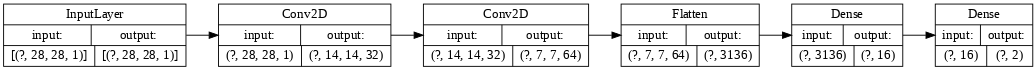

In [62]:
plot_model(ae_encoder, show_shapes=True, show_layer_names=False, dpi=65, rankdir='LR')

---
## 2 - Conv-AE Decoder

Next, we define the Decoder model

The architechture is as follow:
<pre>
    * the input shape is 1-dimensional <font color='blue'><b>(2,)</b></font>  
    * <b>dense</b> layer with <font color='blue'><b>7*7*64</b></font> neurons using relu activation
    * <b>reshape</b> layer to convert input into <font color='blue'><b>(7,7,64)</b></font> 3-dimensional matrix
    * <b>conv2dtranspose</b> layer with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * <b>conv2dtranspose</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * output <b>conv2dtranspose</b> layer with <font color='blue'><b>1</b></font> filters of <font color='blue'><b>3x3</b></font>, and <b>sigmoid</b> activation
</pre>

---
#### <font color='red'>**EXERCISE:** </font>

* build decoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [0]:
# create Input() with shape of latent_dim
# set the name as 'decoder_input'
decoder_input = Input(shape=latent_dim, name='decoder_input')


# add dense layer to decoder_input with 7*7*64 neurons and relu activation
x = Dense(7*7*64, activation='relu') (decoder_input)

# add reshape layer to x to reshape back into (7, 7, 64)
x = Reshape((7, 7, 64)) (x)

# add con2dtranspose to x with 64 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)

# add con2dtranspose to x with 32 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)


# add output layer to x using con2dtranspose layer with 1 filter, 
# kernel size 3, sigmoid activation, and padding same
# set the name as 'decoder_output'
decoder_output = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='SAME', 
                                 name='decoder_output') (x)



---
#### <font color='red'>**EXERCISE:** </font>
* instantiate decoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [64]:
# call Model() function with input decoder_input and decoder_output
# set the model name as 'ae_decoder'
ae_decoder = Model(decoder_input, decoder_output, name='ae_decoder')

ae_decoder.summary()

Model: "ae_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
____________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "ae_decoder"
decoder_input (InputLayer)   [(None, 2)]               0         
dense_? (Dense)              (None, 3136)              9408      
reshape_? (Reshape)          (None, 7, 7, 64)          0         
conv2d_transpose_? (Conv2DTr (None, 14, 14, 64)        36928     
conv2d_transpose_? (Conv2DTr (None, 28, 28, 32)        18464     
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
=================================================================
Total params: 65,089

Visualize the network architecture

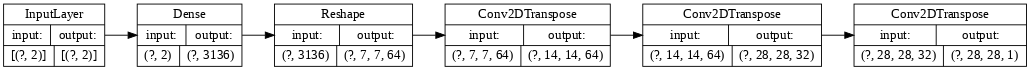

In [65]:
plot_model(ae_decoder, show_shapes=True, show_layer_names=False, dpi=65, rankdir='LR')

---
## 3 - Conv-AutoEncoder 

Lastly, we combine the Encoder and Decoder into single AutoEncoder model

---
#### <font color='red'>**EXERCISE:** </font>
*  instantiate DCAE model = Encoder + Decoder
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED

In [66]:
# call ae_encoder() function with input encoder_input
encoded  = ae_encoder(encoder_input)

# call ae_decoder() function with input encoded
decoder_output = ae_decoder(encoded)

# call Model() function with input encoder_input and decoder_output
# set the model name as 'conv_autoencoder'
autoenc = Model(encoder_input, decoder_output, name='conv_autoencoder')

autoenc.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
ae_encoder (Model)           (None, 2)                 69042     
_________________________________________________________________
ae_decoder (Model)           (None, 28, 28, 1)         65089     
Total params: 134,131
Trainable params: 134,131
Non-trainable params: 0
_________________________________________________________________


**EXPECTED OUTPUT**:
<pre>
Model: "conv_autoencoder"
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
ae_encoder (Model)           (None, 2)                 69042     
ae_decoder (Model)           (None, 28, 28, 1)         65089     
Total params: 134,131

Visualize the network architecture

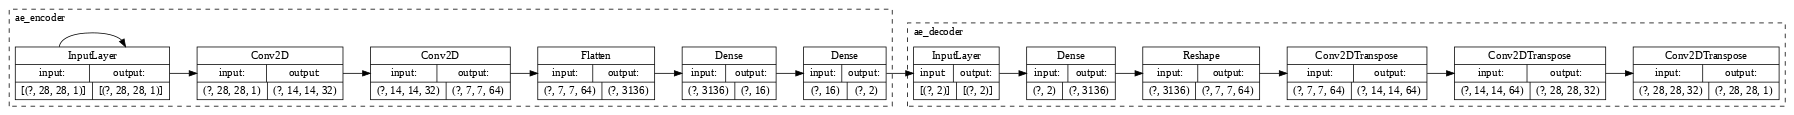

In [67]:
plot_model(autoenc, show_shapes=True, show_layer_names=False, dpi=55, rankdir='LR', expand_nested=True)

---
## 4 - Train Convolutional AutoEncoder

The next step is to train the model

---
### a. Compile Model
First let's compile using the model using adam optimizer and binary_crossentropy loss

---
#### <font color='red'>**EXERCISE:** </font>
compile `autoenc` model using `'adam'` optimizer and `'binary_crossentropy'` loss

In [0]:
autoenc.compile(optimizer='adam', loss='binary_crossentropy')

---
### b. Train DC-AE

Then train the model for 50 epochs

In [69]:
batch_size  = 512
epochs      = 50

base_dir = 'conv_ae'
tf.io.gfile.mkdir(base_dir)
myCallback = SaveImage(ae_decoder, base_dir)

ae_hist = autoenc.fit(x_train, x_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test),
                      callbacks = [myCallback],
                      verbose=2
                      )


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 - 105s - loss: 0.3492 - val_loss: 0.2558
Epoch 2/50
60000/60000 - 104s - loss: 0.2444 - val_loss: 0.2322
Epoch 3/50
60000/60000 - 104s - loss: 0.2247 - val_loss: 0.2181
Epoch 4/50
60000/60000 - 104s - loss: 0.2149 - val_loss: 0.2116
Epoch 5/50
60000/60000 - 104s - loss: 0.2096 - val_loss: 0.2072
Epoch 6/50
60000/60000 - 104s - loss: 0.2056 - val_loss: 0.2037
Epoch 7/50
60000/60000 - 104s - loss: 0.2023 - val_loss: 0.2026
Epoch 8/50
60000/60000 - 104s - loss: 0.1997 - val_loss: 0.1984
Epoch 9/50
60000/60000 - 103s - loss: 0.1977 - val_loss: 0.1970
Epoch 10/50
60000/60000 - 103s - loss: 0.1962 - val_loss: 0.1970
Epoch 11/50
60000/60000 - 103s - loss: 0.1950 - val_loss: 0.1947
Epoch 12/50
60000/60000 - 103s - loss: 0.1937 - val_loss: 0.1936
Epoch 13/50
60000/60000 - 104s - loss: 0.1928 - val_loss: 0.1931
Epoch 14/50
60000/60000 - 104s - loss: 0.1922 - val_loss: 0.1936
Epoch 15/50
60000/60000 - 104s - loss: 0.1914 - v

---
### c. Visualize Loss History

No handles with labels found to put in legend.


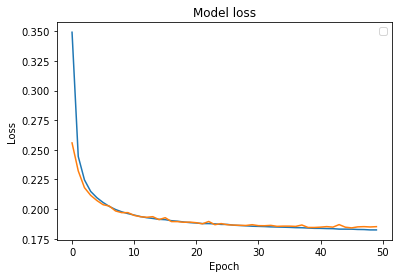

In [70]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(ae_hist.history['loss'])
plt.plot(ae_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---
## 5 - Visualize Generated Images

Now let's visualize the result

---
### a. Latent Space Distribution

Plots labels and MNIST digits as function of 2-dim latent vector

You should see that the distribution of latent vector is clustered by class as AutoEncoder is intended to perform Dimensionality Reduction or Feature Extraction

The clustered distribution is good for Classification purposes, but not for Image Generation

z range: (-8.430345,15.145903)


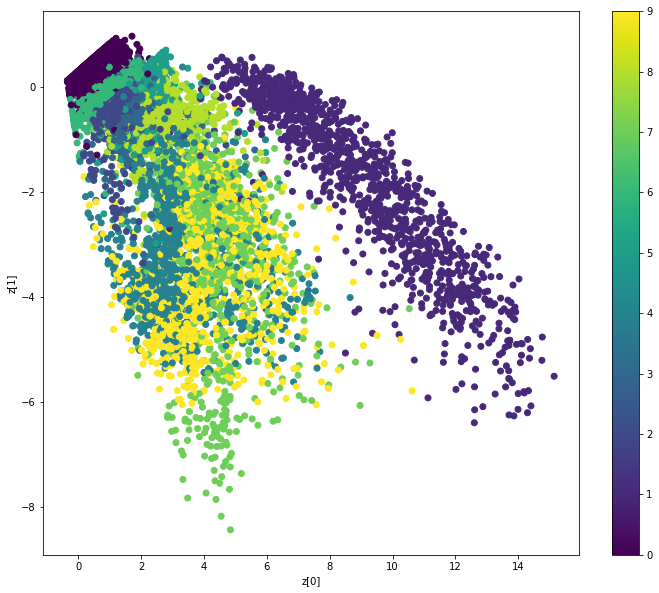

In [71]:
batch_size=128
data_test = (x_test, y_test)
plot_latent_space(ae_encoder, data_test, batch_size=batch_size, vae=False)

---
### b. Reconstructed Images

Next, let's visualzie the Reconstructed Images from several data test

You'll see that using shallow ConvNet and several epochs, we can already perform dimensionality reduction, and reconstruct the reduced data back into its original image

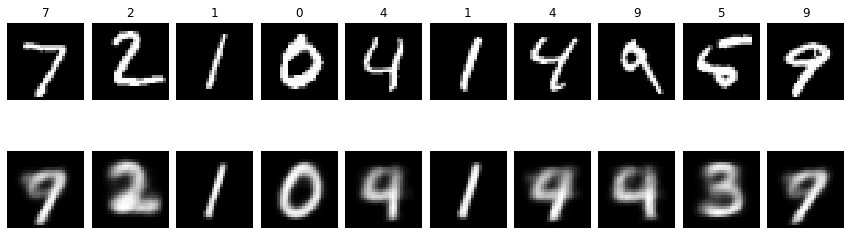

In [72]:
ori_img = x_test[:10]
rec_img = autoenc.predict(ori_img, verbose=0)

fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(10):
    ax[0,i].imshow(ori_img[i].reshape(28, 28), cmap='gray')
    ax[0,i].set_title(y_test[i])
    ax[0,i].axis('off')
    ax[1,i].imshow(rec_img[i].reshape(28, 28), cmap='gray')
    ax[1,i].axis('off')
plt.show()


---
### c. Randomly Generated

Now let's try to generate &nbsp;$5$&nbsp; new images from a random latent vector &nbsp;$z$&nbsp;

You should see that the result is quite good

The network is able to generate new image from random input

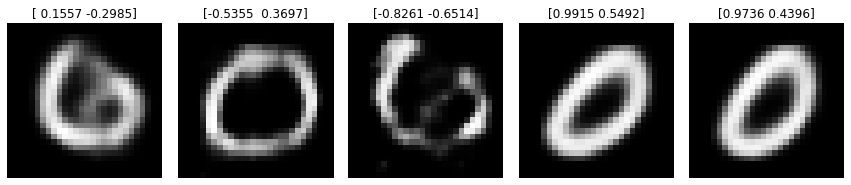

In [73]:
generate_image(ae_decoder)

But what happened if we try to widen the vector random range to $(-5..5)$?

You might see that some images get corrupted because the decoder model is not trained to generate images in that input area

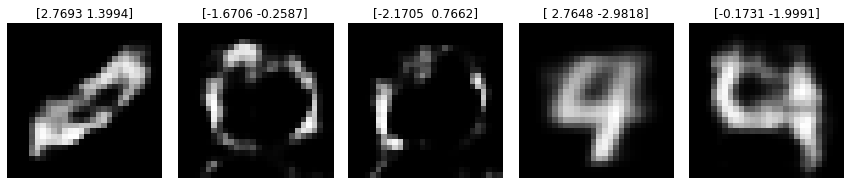

In [74]:
generate_image(ae_decoder, z_range=(-5,5))

You can try to generate single image by running the cell below

you can use predefined latent vector or generate a random vector

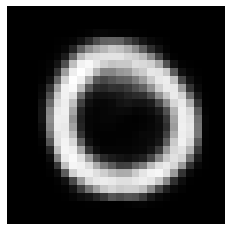

In [75]:
# z_sample = np.random.uniform(-10, 10, (1, 2))
z_sample = np.array([[0,0]])

x_decoded = ae_decoder.predict(z_sample)
digit = x_decoded.reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

---
### d. Plot Interpolation

Now let's generate the image interpolation generated from a range of latent vectors

First we generate $10\times 10$ image ranged from $(-1..1)$

range:( -1 : 1 )


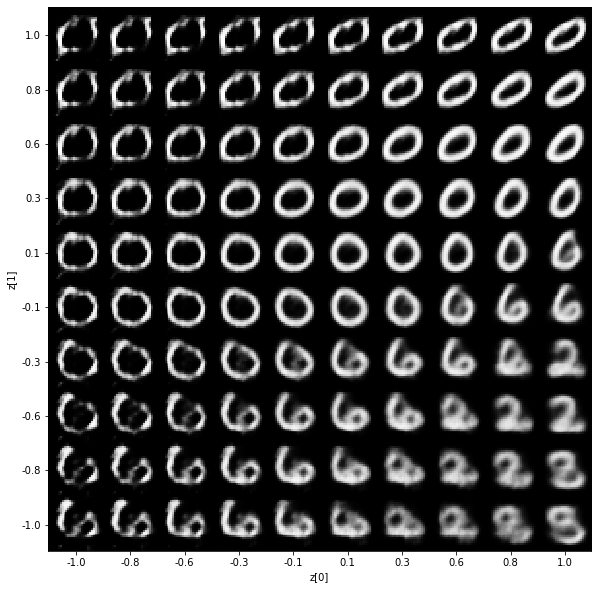

In [76]:
plot_interpolating(ae_decoder, n=10)

Now let's try to widen the range. For that we deepen the interpolation to $20\times 20$

Again, you may notice that in some input ranges, the generated images begin to be unrecognizable

range:( -10 : 10 )


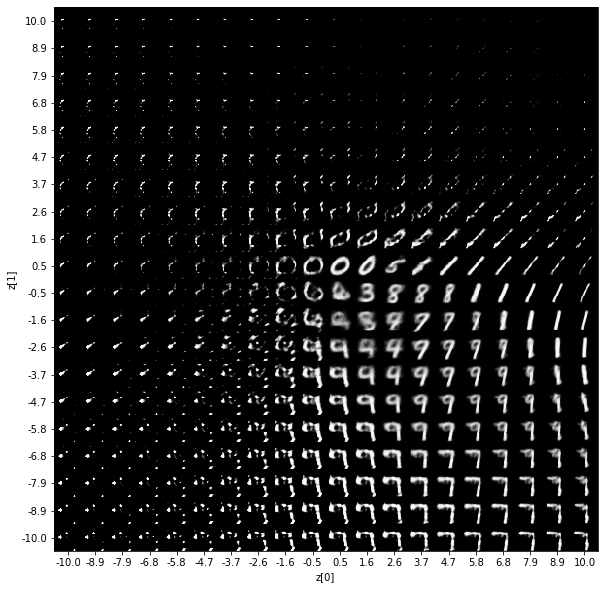

In [77]:
plot_interpolating( ae_decoder, n=20, z_range=(-10,10))

---
### e. Generate GIF

Now this just for fun, we combine the saved image generated each epoch while training into a GIF animation

open the result in Files tab

In [78]:
base_dir = 'conv_ae'

show_gif(base_dir, 'conv_autoenc.gif')

GIF saved as conv_autoenc.gif


---
---
# [Part 2] Variational AutoEncoder

As already mentioned before, the basic idea behind a **Variational Autoencoder** is that instead of mapping an input to fixed vector, input is mapped to a distribution. 

A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

<p align='center'>
<img src="https://miro.medium.com/max/3374/1*22cSCfmktNIwH5m__u2ffA.png" width=80% />

The only difference between the autoencoder and variational autoencoder is that bottleneck vector is replaced with two different vectors one representing the mean of the distribution and the other representing the standard deviation of the distribution.



---
## 0 - Random Sampling Function

Function below is a helper function to generate a random latent vector &nbsp;$z$&nbsp; from input &nbsp;$mean$&nbsp; and &nbsp;$variance$

In [0]:
def sampling(args):
    
  z_mean, z_log_var = args
    
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]

  # by default, random_normal has mean=0 and std=1.0
  epsilon = K.random_normal(shape=(batch, dim))
  
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

---
## 1 - VAE Encoder

This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

<center>
<img src='https://miro.medium.com/max/1608/1*XYyWimolMhPDMg8qCNlcwg@2x.png' width=60%>
</center>

Now to define the Encoder model

The architechture is as follow:
<pre>
    * the input shape is 3-dimensional <font color='blue'><b>(28,28,1)</b></font>  
    * <b>conv</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * <b>conv</b> layer with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * flatten layer
    * <b>dense</b> layer with <font color='blue'><b>16</b></font> neurons using relu activation

    * output 1: <b>dense</b> layer with <font color='blue'><b>2</b></font> neuron without activation
    * output 2: <b>dense</b> layer with <font color='blue'><b>2</b></font> neuron without activation
</pre>

---
#### <font color='red'>**EXERCISE:** </font>

*  build encoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED

In [0]:
input_shape = (image_size, image_size, 1)
latent_dim  = 2

# create Input() with shape of input_shape
# set the name as 'v_encoder_input'
v_encoder_input = Input(input_shape, name='v_encoder_input')

# add conv2d layer to v_encoder_input with 32 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2D(filters=32, kernel_size=2, strides=2, activation='relu', padding='SAME') (v_encoder_input)

# add conv2d layer to x with 64 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)

# add flatten layer to x 
x = Flatten() (x)

# add dense layer to x with 16 neurons and relu activation
x = Dense(16, activation='relu') (x)


# generate latent vector Q(z|X)
# add first output layer to x 
# using dense layer with latent_dim neurons, without activation
# set the name as 'z_mean'
z_mean    = Dense(latent_dim, name='z_mean') (x)

# add first output layer to x 
# using dense layer with latent_dim neurons, without activation
# set the name as 'z_log_var'
z_log_var = Dense(latent_dim, name='z_log_var') (x)

# generate random sampling from z_mean and z_log_var 
# as input for decoder model
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# combine all outputs into a single list
v_encoder_output = [z_mean, z_log_var, z]



---
#### <font color='red'>**EXERCISE:** </font>
* instantiate encoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [81]:
# call Model() function with input v_encoder_input and v_encoder_output
# set the model name as 'vae_encoder'
vae_encoder = Model(v_encoder_input, v_encoder_output, name='vae_encoder')

vae_encoder.summary()

Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
v_encoder_input (InputLayer)    [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 32)   160         v_encoder_input[0][0]            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_13[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 3136)         0           conv2d_14[0][0]                  
________________________________________________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "vae_encoder"
v_encoder_input (InputLayer)    [(None, 28, 28, 1)]  0                                            
conv2d_? (Conv2D)               (None, 14, 14, 32)   320         v_encoder_input[0][0]            
conv2d_? (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
flatten_? (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
dense_? (Dense)                 (None, 16)           50192       flatten_1[0][0]                  
z_mean (Dense)                  (None, 2)            34          dense_2[0][0]                    
z_log_var (Dense)               (None, 2)            34          dense_2[0][0]                    
z (Lambda)                      (None, 2)            0           z_mean[0][0]                     
                                                                 z_log_var[0][0]                  
Total params: 69,076

Visualize the network architecture

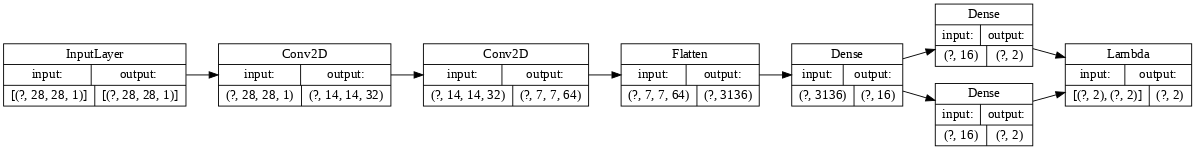

In [82]:
plot_model(vae_encoder, show_shapes=True, show_layer_names=False, dpi=65, rankdir='LR')

---
## 2 - VAE Decoder

Then we define the Decoder model exactly the same as the previous Vanilla Decoder

The architechture is as follow:
<pre>
    * the input shape is 1-dimensional <font color='blue'><b>(2,)</b></font>  
    * <b>dense</b> layer with <font color='blue'><b>7*7*64</b></font> neurons using relu activation
    * <b>reshape</b> layer to convert input into <font color='blue'><b>(7,7,64)</b></font> 3-dimensional matrix
    * <b>conv2dtranspose</b> layer with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * <b>conv2dtranspose</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font>, using stride <font color='blue'><b>2</b></font>, and relu activation
    * output <b>conv2dtranspose</b> layer with <font color='blue'><b>1</b></font> filters of <font color='blue'><b>3x3</b></font>, and <b>sigmoid</b> activation
</pre>

---
#### <font color='red'>**EXERCISE:** </font>

* build decoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [0]:
# create Input() with shape of latent_dim
# set the name as 'v_decoder_input'
v_decoder_input = Input(latent_dim, name='v_decoder_input')


# add dense layer to v_decoder_input with 7*7*64 neurons and relu activation
x = Dense(7*7*64, activation='relu') (v_decoder_input)

# add reshape layer to x to reshape back into (7, 7, 64)
x = Reshape((7,7,64)) (x)

# add con2dtranspose to x with 64 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)

# add con2dtranspose to x with 32 filters, kernel size 3, and strides 2
# use relu activation and padding same
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='SAME') (x)


# add output layer to x using con2dtranspose layer with 1 filter, 
# kernel size 3, sigmoid activation, and padding same
# set the name as 'v_decoder_output'
v_decoder_output = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', 
                                   padding='SAME', name='v_decoder_output') (x)


---
#### <font color='red'>**EXERCISE:** </font>
* instantiate decoder model
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED


In [84]:
# call Model() function with input v_decoder_input and v_decoder_output
# set the model name as 'vae_decoder'
vae_decoder = Model(v_decoder_input, v_decoder_output, name='vae_decoder')

vae_decoder.summary()

Model: "vae_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
v_decoder_input (InputLayer) [(None, 2)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
v_decoder_output (Conv2DTran (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
___________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "vae_decoder"
v_decoder_input (InputLayer) [(None, 2)]               0         
dense_3 (Dense)              (None, 3136)              9408      
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
v_decoder_output (Conv2DTran (None, 28, 28, 1)         289       
Total params: 65,089

Visualize the network architecture

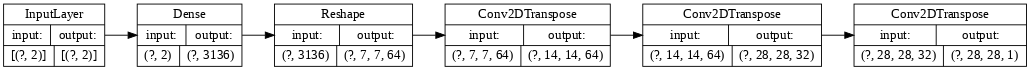

In [85]:
plot_model(vae_decoder, show_shapes=True, show_layer_names=False, dpi=65, rankdir='LR')

---
## 3 - Variational-AutoEncoder 

Now instantiate VAE model = VEncoder + VDecoder

---
#### <font color='red'>**EXERCISE:** </font>
*  instantiate VAE model = V Encoder + V Decoder
*  use Functional API
*  DO NOT FORGET TO NAME THE LAYER AS INSTRUCTED

In [86]:
# call vae_encoder() function with input v_encoder_input
v_encoded  = vae_encoder(v_encoder_input)

# there are three element in output list from vae_encoder: z_mean, z_log_var, and z itself
# we want to get the latent space z, so retrieve the third element of the list
v_encoded  = v_encoded[2]

# call vae_decoder() function with input v_encoded
v_decoder_output = vae_decoder(v_encoded)

# call Model() function with input v_encoder_input and v_decoder_output
# set the model name as 'variational_autoencoder'
vae = Model(v_encoder_input, v_decoder_output, name='variational_autoencoder')

vae.summary()

Model: "variational_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
v_encoder_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
vae_encoder (Model)          [(None, 2), (None, 2), (N 68916     
_________________________________________________________________
vae_decoder (Model)          (None, 28, 28, 1)         65089     
Total params: 134,005
Trainable params: 134,005
Non-trainable params: 0
_________________________________________________________________


**EXPECTED OUTPUT**:
<pre>
Model: "variational_autoencoder"
v_encoder_input (InputLayer) [(None, 28, 28, 1)]       0         
vae_encoder (Model)          [(None, 2), (None, 2), (N 69076     
vae_decoder (Model)          (None, 28, 28, 1)         65089     
Total params: 134,165

Visualize the network architecture

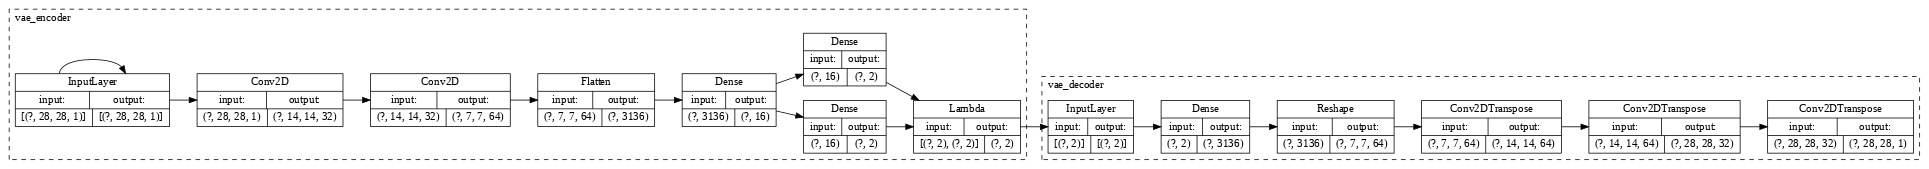

In [87]:
plot_model(vae, show_shapes=True, show_layer_names=False, dpi=55, rankdir='LR', expand_nested=True)

---
## 4 - Train Variational AutoEncoder

Next to train the Variational AutoEncoder

---
### a. Define Loss


<center>
<img src='https://miro.medium.com/max/2080/1*L1klrEWx4Y5Bz6qMqTbwAQ@2x.png' width=60%>
</center>

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

then we calculate the KL term to optimize it, thus we have
$$
D_{KL} = \frac{1}{2}\sum_k\Big(\exp(\Sigma(X))+\mu^2(X)-1-\Sigma(X)\Big)
$$

Now to calculate the total loss is defined by

    VAE loss = mse_loss + kl_loss


In [0]:
from tensorflow.keras.losses import mse

# calculate construction loss
# --> mse loss
reconstruction_loss = mse(K.flatten(v_encoder_input), K.flatten(v_decoder_output))
reconstruction_loss *= 28 * 28

# calculate KL Loss
kl_loss = K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.5

# calculate VAE Loss
vae_loss = K.mean(reconstruction_loss + kl_loss)

---
### b. Compile Model
Add loss to model and compile it

In [89]:
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

---
### c. Train DC-VAE
Then train the model for 50 epochs

In [90]:
batch_size  = 512
epochs      = 50

base_dir = 'var_ae'
tf.io.gfile.mkdir(base_dir)
myCallback = SaveImage(vae_decoder, base_dir)

vae_hist = vae.fit(x_train, 
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(x_test, None),
                   callbacks = [myCallback],
                   verbose=2
                   )


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 - 117s - loss: 72.0857 - val_loss: 53.9997
Epoch 2/50
60000/60000 - 116s - loss: 52.5632 - val_loss: 50.6831
Epoch 3/50
60000/60000 - 116s - loss: 49.5381 - val_loss: 48.8542
Epoch 4/50
60000/60000 - 116s - loss: 48.2956 - val_loss: 47.8072
Epoch 5/50
60000/60000 - 116s - loss: 47.5118 - val_loss: 47.1645
Epoch 6/50
60000/60000 - 116s - loss: 46.9316 - val_loss: 46.5955
Epoch 7/50
60000/60000 - 116s - loss: 44.8066 - val_loss: 43.3183
Epoch 8/50
60000/60000 - 116s - loss: 42.7000 - val_loss: 42.3778
Epoch 9/50
60000/60000 - 116s - loss: 42.0155 - val_loss: 41.7248
Epoch 10/50
60000/60000 - 116s - loss: 41.5097 - val_loss: 41.4530
Epoch 11/50
60000/60000 - 115s - loss: 41.1248 - val_loss: 41.2102
Epoch 12/50
60000/60000 - 115s - loss: 40.8902 - val_loss: 40.8584
Epoch 13/50
60000/60000 - 115s - loss: 40.6212 - val_loss: 40.5448
Epoch 14/50
60000/60000 - 116s - loss: 40.3876 - val_loss: 40.4570
Epoch 15/50
60000/600

---
### d. Visualize Loss History

In [0]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(vae_hist.history['loss'])
plt.plot(vae_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---
## 5 - Visualize Generated Images

Now let's visualize the result

---
### a. Latent Space Distribution

Plots labels and MNIST digits as function of 2-dim latent vector

You should see that now the latent vector is more smoothly distributed across the space

In [0]:
batch_size=128
data_test = (x_test, y_test)

plot_latent_space(vae_encoder, data_test, batch_size=batch_size, vae=True)

---
### b. Randomly Generated

Now we skip directly to generate &nbsp;$5$&nbsp; new images from a random latent vector &nbsp;$z$&nbsp;

You should see that the result is better

The network is able to generate new image from random input

In [0]:
generate_image(vae_decoder)

But what happened if we try to widen the vector random range to $(-5..5)$?

You might see that the image is much better that using Vanilla AutoEncoder, even though the network is not trained to generate image from that range

In [0]:
generate_image(vae_decoder, z_range=(-5,5))

You can try to generate single image by running the cell below

you can use predefined latent vector or generate a random vector

In [0]:
z_sample = np.array([[0,0]])
x_decoded = vae_decoder.predict(z_sample)
digit = x_decoded.reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

---
### c. Plot Interpolation

Next let's generate the image interpolation generated from a range of latent vectors

First we generate $10\times 10$ image ranged from $(-1..1)$

You may see that the interpolation is done more smoothly

In [0]:
plot_interpolating(vae_decoder, n=10)

Now let's try to widen the range. For that we deepen the interpolation to $20\times 20$

You might see that the interpolation still results smooth images across wide range

In [0]:
plot_interpolating( vae_decoder, n=20, z_range=(-5,5))

---
### d. Generate GIF

Now this just for fun, we combine the saved image generated each epoch while training into a GIF animation

open the result in Files tab

In [0]:
base_dir = 'var_ae'

show_gif(base_dir, 'var_autoenc.gif')

GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as var_autoenc.gif
GIF saved as v

---
---

# Congratulation, You've Completed Exercise 15
<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2019 - ADF</a> </p>

![footer](https://image.ibb.co/hAHDYK/footer2018.png)